# 캡스톤 디자인

## 개요
만들어야 할 모델 : Focus Model(집중도 분석 모델).  
라벨 : 집중, 집중하지 않음, 졸음 (3가지).  
프레임워크 : Pytorch(나중에는 ONNX->TFLite로 변경해줘야 Flutter에서 사용할 수 있다.)


## 사용할 모델
mobileNetV3 : https://huggingface.co/timm/mobilenetv3_small_100.lamb_in1k

## Model Details
- Model Type: Image classification / feature backbone
- Model Stats:
    - Params (M): 2.5
    - GMACs: 0.1
    - Activations (M): 1.4
    - Image size: 224 x 224
- Papers:
    - Searching for MobileNetV3: https://arxiv.org/abs/1905.02244
- Dataset: ImageNet-1k
- Original: https://github.com/huggingface/pytorch-image-models
[출처]:https://huggingface.co/timm/mobilenetv3_small_100.lamb_in1k

## 사용할 학습 데이터   
AI-Hub : https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=data&dataSetSn=71715
- 학습 데이터
    - focused(집중): 
    - not focused(집중하지 않음): 
    - drowsy(졸음): 
    - 총 개

- 평가 데이터
    - focused(집중): 
    - not focused(집중하지 않음): 
    - drowsy(졸음): 
    - 총 개

## 추가 데이터 세트
(필요 없을거 같다..)   
UTA-RLDD : <https://sites.google.com/view/utarldd/home>   
우리의 주제와 비슷한 맥락의 연구에서 사용된 데이터셋 -> 동영상 데이터만 존재, 라벨 데이터가 없음

## 사용한 라이브러리
- pandas: pip install pandas
- matplotlib: pip install matplotlib
- opencv-python: pip install opencv-python
- timm: pip install timm
- tqdm: pip install tqdm
- pytorch: https://pytorch.kr/get-started/locally/
- scikit-learn: pip install scikit-learn
- albumentations: pip install albumentations
- torchmetrics: pip install torchmetrics

## 참고 자료
https://www.nature.com/articles/s41598-024-79146-z


## 코드에서 바꿔야할 사항
- 데이터 경로 설정
- 모델 체크포인트 경로

<hr/>

## 데이터 불러오기

In [ ]:
import os
import pandas as pd

data_path = "/users/kimjohyeon/Desktop/Capstone/cropped_faces" # 데이터 경로 작성하면 됨.
paths= []
labels = []

for path, _, filenames in os.walk(data_path):
    for filename in filenames:
        if '.jpg' in filename:
            file_path = path + '/' + filename
            paths.append(file_path)

            if '/drowsy' in file_path:
                labels.append("drowsy")
            elif '/focused' in file_path:
                labels.append('focused')
            elif '/not_focused' in file_path:
                labels.append('not_focused')
            else:
                labels.append('N/A')

data_df = pd.DataFrame({"path":paths, "label":labels})
label_mapping = {"focused":0, "not_focused":1, "drowsy":2}

data_df["target"] = data_df["label"].map(label_mapping)
data_df.head()


,path,label,target
0,/users/kimjohyeon/Desktop/Capstone/cropped_fac...,focused,0
1,/users/kimjohyeon/Desktop/Capstone/cropped_fac...,focused,0
2,/users/kimjohyeon/Desktop/Capstone/cropped_fac...,focused,0
3,/users/kimjohyeon/Desktop/Capstone/cropped_fac...,focused,0
4,/users/kimjohyeon/Desktop/Capstone/cropped_fac...,focused,0


In [9]:
# 이미지 경로가 제대로 설정되었는지 확인
import cv2

image = cv2.imread(data_df["path"][0])
image.shape

(252, 252, 3)

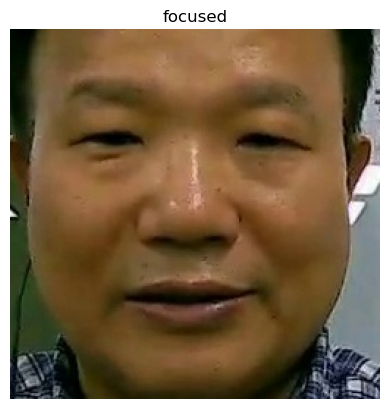

In [11]:
import matplotlib.pyplot as plt

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)
plt.title(data_df["label"][0])
plt.axis(False)
plt.show()

In [ ]:
# 데이터 개수 확인
focus_count = data_df[data_df["label"]=="focused"]["label"].count()
not_focus_count = data_df[data_df["label"]=="not_focused"]["label"].count()
drowsy_count = data_df[data_df["label"]=="drowsy"]["label"].count()
total_count = data_df["label"].count() if (focus_count + not_focus_count + drowsy_count) == data_df["label"].count() else "error"

# 개수가 맞으면 total이 총합으로 나올 것이고, error가 출력된다면 결측값이 있다는 것이다.
print(f"Focused: {focus_count}\nNot Focused: {not_focus_count}\nDrowsy: {drowsy_count}\n\nTotal: {total_count}")

Focused: 455
Not Focused: 417
Drowsy: 206

Total: 1078


In [13]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data_df, test_size=0.1, stratify=data_df["target"], random_state=2025)
tr_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df["target"], random_state=2025)

train_df.shape, tr_df.shape, val_df.shape, test_df.shape

((970, 3), (824, 3), (146, 3), (108, 3))

## Dataset, DataLoader 생성

In [14]:
# 데이터셋 만드는 클래스
import torch
import torch.nn as nn
import cv2
import numpy as np

class FocusDataset(nn.Module):
    def __init__(self, image_paths, targets=None, transform=None):
        self.image_paths = image_paths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_np = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB).astype(np.float32)
        image = self.transform(image=image_np)["image"]

        if self.targets is not None:
            target = torch.tensor(self.targets[idx])

            return image, target
        
        return image

In [17]:
import albumentations as A
from albumentations import ToTensorV2
from torch.utils.data import DataLoader

IMG_SIZE = 224
IMG_MEANS = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]
BATCH_SIZE = 16

tr_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, p=1),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=IMG_MEANS, std=IMG_STD),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=IMG_MEANS, std=IMG_STD),
    ToTensorV2()
])

def create_tr_val_loader(tr_df, val_df, tr_transform, val_transform):
    tr_dataset = FocusDataset(image_paths=tr_df["path"].to_list(), targets=tr_df["target"].to_list(), transform=tr_transform)
    tr_loader = DataLoader(tr_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
    if val_df is not None:
        val_dataset = FocusDataset(image_paths=val_df["path"].to_list(), targets=val_df["target"].to_list(), transform=val_transform)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

        return tr_loader, val_loader
    
    return tr_loader, None

tr_loader, val_loader = create_tr_val_loader(tr_df, val_df, tr_transform, val_transform)


In [18]:
images, targets = next(iter(tr_loader))
print(images.shape, targets.shape)

torch.Size([16, 3, 224, 224]) torch.Size([16])


## 모델 생성

In [19]:
import timm
mobilenetv3_s_100 = timm.create_model(model_name="mobilenetv3_large_100", pretrained=True, num_classes=3)

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

## Trainer, Predictor, ModelCheckpoint, EarlyStopping

In [20]:
from tqdm import tqdm
import torch.nn.functional as F

class Trainer:
    def __init__(self, model, loss_fn, optimizer, tr_loader, val_loader, scheduler=None, callbacks=None, metric=None, device=None):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.tr_loader = tr_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.callbacks = callbacks
        self.metric = metric.to(device)
        self.device = device
        self.current_lr = self.optimizer.param_groups[0]['lr']
    
    def train_epoch(self, epoch):
        self.model.train()

        accu_loss = 0.0
        running_avg_loss = 0.0

        self.metric.reset()
        with tqdm(total=len(self.tr_loader), desc=f"Epoch {epoch+1} [Training..]", leave=True) as progress_bar:
            for batch_idx, (inputs, targets) in enumerate(self.tr_loader):
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                accu_loss += loss.item()
                running_avg_loss = accu_loss / (batch_idx + 1)

                pred_proba = F.softmax(outputs, dim=-1)
                self.metric.update(pred_proba, targets)

                progress_bar.update(1)
                if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:
                    progress_bar.set_postfix({"Loss":running_avg_loss,
                                              "Metrix":self.metric.compute().item()})

        if self.scheduler is not None and not(isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau)):
            self.scheduler.step(running_avg_loss)
            self.current_lr = self.scheduler.get_last_lr()[0]
        
        return running_avg_loss, self.metric.compute().item()
    
    def valid_epoch(self, epoch):
        if self.val_loader is None:
            return None, None
        
        self.model.eval()
        accu_loss = 0.0
        running_avg_loss = 0.0

        self.metric.reset()
        with tqdm(total=len(self.val_loader), desc=f"Epoch {epoch+1} [Validation]", leave=True) as progress_bar:
            for batch_idx, (inputs, targets) in enumerate(self.val_loader):
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                outputs = self.model(inputs)

                loss = self.loss_fn(outputs, targets)
                accu_loss += loss.item()
                running_avg_loss = accu_loss / (batch_idx + 1)

                pred_proba = F.softmax(outputs)
                self.metric.update(pred_proba, targets)

                progress_bar.update(1)
                if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:
                    progress_bar.set_postfix({"Loss":running_avg_loss, 
                                          "Metrix":self.metric.compute().item()})
                    
        if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            self.scheduler.step(running_avg_loss)
            self.current_lr = self.scheduler.get_last_lr()[0]

        return running_avg_loss, self.metric.compute().item()
    
    def fit(self, epochs):
        history = {"train_loss" : [], "train_metric" : [], "val_loss" : [], "val_metric" : [], "lr" : []}
        for epoch in range(epochs):
            train_loss, train_metric = self.train_epoch(epoch)
            val_loss, val_metric = self.valid_epoch(epoch)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f} Train Auc: {train_metric:.4f}",
                  f", Val Loss: {val_loss:.4f} Val Auc: {val_metric:.4f}" if val_loss is not None else "",
                  f", Current lr:{self.current_lr:.6f}")
            history["train_loss"].append(train_loss); history["train_metric"].append(train_metric)
            history["val_loss"].append(val_loss); history["val_metric"].append(val_metric)
            history["lr"].append(self.current_lr)
        
            if self.callbacks:
                is_epoch_loop_break = self._execute_callbacks(self.callbacks, self.model, epoch, val_loss, val_metric)
                if is_epoch_loop_break:
                    break

        return history
    
    def _execute_callbacks(self, callbacks, model, epoch, val_loss, val_metric):
        is_epoch_loop_break = False

        for callback in self.callbacks:
            if isinstance(callback, ModelCheckpoint):
                if callback.monitor == 'val_loss':
                    callback.save(model, epoch, val_loss)
                elif callback.monitor == 'val_metric':
                    callback.save(model, epoch, val_metric)

            if isinstance(callback, EarlyStopping):
                if callback.monitor == 'val_loss':
                    is_epoch_loop_break = callback.check_early_stop(val_loss)
                elif callback.monitor == 'val_metric':
                    is_epoch_loop_break = callback.check_early_stop(val_metric)

        return is_epoch_loop_break
    
    def get_trained_model(self):
        return self.model




In [11]:
class Predictor:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device

    def evaluate(self, loader):
        # 현재 입력으로 들어온 데이터의 batch 통계(mean, variance)를 사용하지 않고, 학습 시 계산된 running 통계값을 사용
        self.model.eval()
        eval_metric = 0.0
        # 정확도 계산을 위한 전체 건수 및 누적 정확건수
        num_total = 0.0
        accu_num_correct = 0.0

        with tqdm(total=len(loader), desc=f"[Evaluating]", leave=True) as progress_bar:
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    pred = self.model(inputs)

                    # 정확도 계산을 위해 누적 전체 건수와 누적 전체 num_correct 건수 계산  
                    num_correct = (pred.argmax(-1) == targets).sum().item()
                    num_total += inputs.shape[0]
                    accu_num_correct += num_correct
                    eval_metric = accu_num_correct / num_total

                    progress_bar.update(1)
                    if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:
                        progress_bar.set_postfix({"Accuracy": eval_metric})
        
        return eval_metric

    def predict_proba(self, inputs):
        self.model.eval()
        with torch.no_grad():
            inputs = inputs.to(self.device)
            outputs = self.model(inputs)
            #예측값을 반환하므로 targets은 필요 없음.
            #targets = targets.to(self.device)
            pred_proba = F.softmax(outputs, dim=-1) #또는 dim=1

        return pred_proba

    def predict(self, inputs):
        pred_proba = self.predict_proba(inputs)
        pred_class = torch.argmax(pred_proba, dim=-1)

        return pred_class

In [21]:
import os
import torch

class ModelCheckpoint:
    def __init__(self, checkpoint_dir='checkpoints', monitor='val_loss', mode='min', save_interval=1, verbose=1):
        self.checkpoint_dir = checkpoint_dir
        self.monitor = monitor
        self.mode = mode
        self.best_value = float('inf') if mode == 'min' else -float('inf')
        self.verbose = verbose
        self.save_interval = save_interval
        self._make_checkpoint_dir_unless()

    def _make_checkpoint_dir_unless(self):
        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)
    
    # mode 유형에 따라 metric value값이 이전 epoch시 보다 향상 되었는지 확인하여 True/False 값 return
    def is_improvement(self, value):
        if self.mode == 'min':
            return value < self.best_value
        else:
            return value > self.best_value

    # self.best_value값 update, is_improvement() 반환값이 True인 경우만 수행. 
    def update_best_value(self, value):
        self.best_value = value

    def save(self, model, epoch, value):
        if self.save_interval == 1:
            if self.is_improvement(value):
                self._checkpoint_save(model, epoch, value)
                self.update_best_value(value)
            
        elif self.save_interval > 1:
            if (epoch + 1) % self.save_interval == 0:
                self._checkpoint_save(model, epoch, value)
            
    def _checkpoint_save(self, model, epoch, value):
        checkpoint_path = os.path.join(self.checkpoint_dir, 
                                       f'checkpoint_epoch_{epoch+1}_{self.monitor}_{value:.4f}.pt')
        torch.save(model.state_dict(), checkpoint_path)
        if self.verbose:
            print(f"Saved model checkpoint at {checkpoint_path}")

In [22]:
class EarlyStopping:
    def __init__(self, monitor='val_loss', mode='min', early_patience=5, verbose=1):
        self.monitor = monitor
        self.mode = mode
        self.early_patience = early_patience
        self.verbose = verbose
        self.best_value = float('inf') if mode == 'min' else -float('inf')
        self.counter = 0

    def is_improvement(self, value):
        if self.mode == 'min':
            return value < self.best_value
        else:
            return value > self.best_value

    def check_early_stop(self, value):
        is_early_stopped = False
        
        if self.is_improvement(value):
            self.best_value = value
            self.counter = 0
            is_early_stopped =False
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.early_patience}")
            if self.counter >= self.early_patience:
                is_early_stopped = True
                if self.verbose:
                    print("Early stopping happens and train stops")
        
        return is_early_stopped
        

## Training

In [23]:
import torch.optim as optim
from torch.optim import Adam

def train_focus(model, tr_df, val_df, tr_transform, val_transform, 
                metric=None, learning_rate=1e-3, lr_scheduler_fn=None, 
                callbacks=None, epochs=30):
    tr_loader, val_loader = create_tr_val_loader(tr_df=tr_df, val_df=val_df, 
                                                 tr_transform=tr_transform, val_transform=val_transform)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = lr_scheduler_fn(optimizer)

    trainer = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer, 
                      tr_loader=tr_loader, val_loader=val_loader, scheduler=scheduler, callbacks=callbacks,
                      metric=metric, device=device)
    history = trainer.fit(epochs)

    return trainer, history

In [24]:
from torchmetrics.classification import AUROC, Accuracy

acu_metric = AUROC(task='multiclass', num_classes=3)

def get_reduce_lr_scheduler(optimizer):
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.2, patience=3, threshold=0.01, min_lr=1e-7)
    
    return lr_scheduler

model_checkpoint = ModelCheckpoint('/users/kimjohyeon/Desktop/Zypt_Model/checkpoint', monitor='val_metric', mode='max') # 체크포인트 위치 변경.
early_stopping = EarlyStopping(monitor='val_metric', mode='max', early_patience=5, verbose=1)
trainer_mobilenetv3_s_100, history = train_focus(mobilenetv3_s_100, tr_df=tr_df, val_df=val_df,
                                  tr_transform=tr_transform, val_transform=val_transform,
                                  metric=acu_metric, learning_rate=1e-3, 
                                  lr_scheduler_fn=get_reduce_lr_scheduler, callbacks=[model_checkpoint, early_stopping], 
                                  epochs=100)


Epoch 1 [Validation]:   0%|          | 0/10 [00:00<?, ?it/s]/var/folders/d0/hmz4pp5x04s8h15wtzsgw_zm0000gn/T/ipykernel_20794/1188845218.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_proba = F.softmax(outputs)
Epoch 1 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s, Loss=0.00472, Metrix=1]


Epoch 1/100, Train Loss: 0.6644 Train Auc: 0.9926 , Val Loss: 0.0047 Val Auc: 1.0000 , Current lr:0.001000
Saved model checkpoint at /users/kimjohyeon/Desktop/Zypt_Model/checkpoint/checkpoint_epoch_1_val_metric_1.0000.pt


Epoch 2 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s, Loss=0.032, Metrix=1]


Epoch 2/100, Train Loss: 0.0058 Train Auc: 1.0000 , Val Loss: 0.0320 Val Auc: 1.0000 , Current lr:0.001000
EarlyStopping counter: 1/5


Epoch 3 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s, Loss=1.97e-6, Metrix=1]


Epoch 3/100, Train Loss: 0.0805 Train Auc: 0.9991 , Val Loss: 0.0000 Val Auc: 1.0000 , Current lr:0.001000
EarlyStopping counter: 2/5


Epoch 4 [Validation]: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s, Loss=7.28e-6, Metrix=1]


Epoch 4/100, Train Loss: 0.8726 Train Auc: 0.9916 , Val Loss: 0.0000 Val Auc: 1.0000 , Current lr:0.001000
EarlyStopping counter: 3/5


Epoch 5 [Validation]: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s, Loss=0.222, Metrix=0.998]


Epoch 5/100, Train Loss: 0.6369 Train Auc: 0.9940 , Val Loss: 0.2224 Val Auc: 0.9984 , Current lr:0.001000
EarlyStopping counter: 4/5


Epoch 6 [Validation]: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s, Loss=0, Metrix=1]

Epoch 6/100, Train Loss: 0.1240 Train Auc: 0.9989 , Val Loss: 0.0000 Val Auc: 1.0000 , Current lr:0.001000
EarlyStopping counter: 5/5
Early stopping happens and train stops


## Train & Validation 데이터의 Loss, Metric 시각화

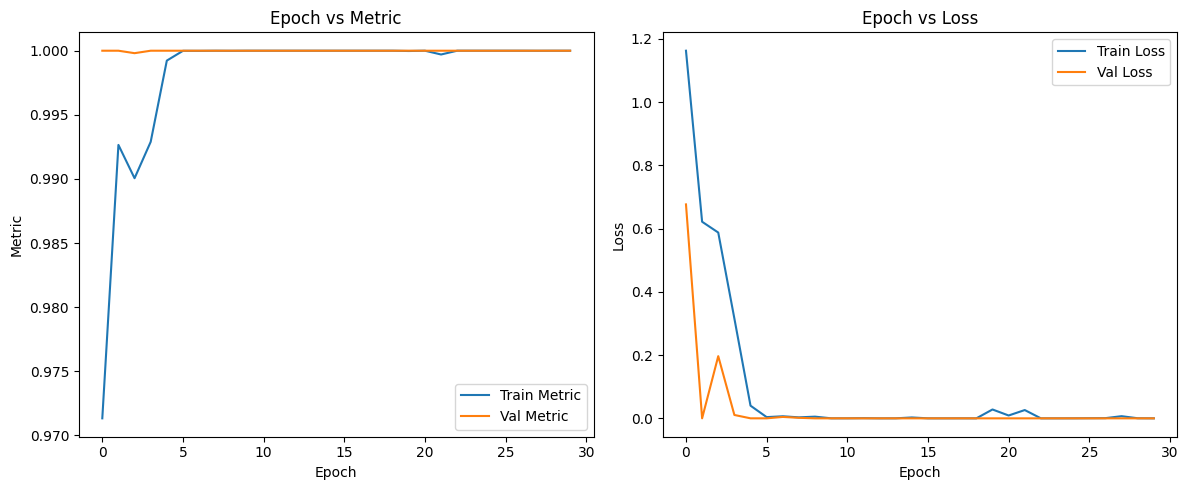

In [65]:
import matplotlib.pyplot as plt

# Metric 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_metric'], label='Train Metric')
plt.plot(history['val_metric'], label='Val Metric')
plt.title('Epoch vs Metric')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

# 손실 시각화
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Test

In [53]:
test_image_paths = test_df['path'].to_list()

test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
# targets는 None
test_dataset = FocusDataset(image_paths=test_image_paths, 
                            targets=None, transform=test_transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

images = next(iter(test_loader))
print(images.shape)
# 아래는 image tensor만 반환함. target값 없음. 
# print(test_dataset[0])

torch.Size([64, 3, 224, 224])


In [54]:
# 모든 테스트 데이터에 대해서 예측 수행 후 numpy로 반환 
def get_all_proba(predictor, test_loader):
    proba_all_list = []
    
    for images in test_loader:
        probas = predictor.predict_proba(images).cpu().numpy()
        # 개별 원소값으로 저장해야 하므로 append()가 아니라 extend()로 list에 저장. 
        proba_all_list.extend(probas)

    proba_all = np.array(proba_all_list)

    return proba_all

In [55]:
# 가장 검증 성능이 좋은 weight 파일을 모델로 로딩. 
state_dict = torch.load('/kaggle/working/checkpoint_epoch_1_val_metric_1.0000.pt', weights_only=True)
best_trained_model = timm.create_model(model_name="mobilenetv3_large_100", pretrained=False, num_classes=3)
best_trained_model.load_state_dict(state_dict)

<All keys matched successfully>

In [56]:
# best_trained_model = trainer_effb1_01.get_trained_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictor = Predictor(model=best_trained_model, device=device)

proba_all = get_all_proba(predictor, test_loader)

In [57]:
proba_all_df = pd.DataFrame(proba_all)
proba_all_df.columns = ["focused", "not focused", "drowsy"]
proba_all_df["predict"] = proba_all_df.idxmax(axis=1)
proba_all_df.head()

,focused,not focused,drowsy,predict
0,1.000000e+00,5.073416e-18,7.264878e-22,focused
1,1.000000e+00,7.707131e-20,8.098269e-18,focused
2,1.000000e+00,6.953874e-18,1.087726e-12,focused
3,1.000000e+00,1.282285e-19,5.168455e-16,focused
4,2.676514e-17,2.361757e-22,1.000000e+00,drowsy


In [59]:
test_df_reset = test_df.reset_index(drop=True)
test_df_reset.head()

,path,label,target
0,/kaggle/input/sorted-faces/sorted_faces/focuse...,focused,0
1,/kaggle/input/sorted-faces/sorted_faces/focuse...,focused,0
2,/kaggle/input/sorted-faces/sorted_faces/focuse...,focused,0
3,/kaggle/input/sorted-faces/sorted_faces/focuse...,focused,0
4,/kaggle/input/sorted-faces/sorted_faces/drowsy...,drowsy,2


In [60]:
result_df = pd.concat([test_df_reset["label"], proba_all_df], axis=1)
result_df

,label,focused,not focused,drowsy,predict
0,focused,1.000000e+00,5.073416e-18,7.264878e-22,focused
1,focused,1.000000e+00,7.707131e-20,8.098269e-18,focused
2,focused,1.000000e+00,6.953874e-18,1.087726e-12,focused
3,focused,1.000000e+00,1.282285e-19,5.168455e-16,focused
4,drowsy,2.676514e-17,2.361757e-22,1.000000e+00,drowsy
...,...,...,...,...,...
103,not_focused,9.909838e-01,9.016167e-03,1.527393e-10,focused
104,drowsy,4.423182e-05,1.379021e-17,9.999558e-01,drowsy
105,focused,1.000000e+00,9.485944e-19,4.757272e-13,focused
106,drowsy,6.654373e-13,2.211255e-22,1.000000e+00,drowsy


In [70]:
max_proba_all = np.argmax(proba_all, axis=1)
target_np = test_df["target"].to_numpy()

In [71]:
count = 0
for i in range(len(test_df)):
    if target_np[i] == max_proba_all[i]:
        count += 1

print(count / len(test_df))

0.8888888888888888
